In [3]:
ls -d data*

data_2013_2d_asbuilt_impaired_0.61m/
data_2013-2d-slr0ft-v04/
data_2013-2d-slr0ft-v05/
data_2013-2d-slr0ft-v05a/
data_2013-2d-slr0ft-v06/
data_2013-2d-slr0ft-v07/
data_2013-2d-slr0ft-v08/
data_2013-2d-slr0ft-v09/
data_2013-2d-slr0ft-v10/
data_2013-2d-slr0ft-v11/
data_2013-2d-slr0ft-v11nobmi/
data_2013-2d-slr0ft-v12nobmi/
data_2013-2d-slr0ft-v13/
data_2013-2d-slr0ft-v13r/
data_2013-2d-slr0ft-v14/
data_2013-2d-slr2ft-v00/
data_2013-2d-slr2ft-v01/
data_2013-2d-slr2ft-v02/
data_2013-2d-slr2ft-v03/
data_2013-2d-slr2ft-v14/
data_2013-2d-v00/
data_2016_2d_asbuilt_impaired_scen1/
data_2016_2d_asbuilt_impaired_scen2/
data_2016_2d_asbuilt_impaired_scen3/
data-2016-3d-asbuilt-impaired-v06/
data_evap_v001/
data_evap_v002/
data_highflow_v019/
data_mouth_v009/
data_mouth_v019/
data_salt_filling-v02/
data_salt_filling-v03/
data_salt_filling-v04_asbuilt_impaired/
data_salt_filling-v04_asbuilt_unimpaired/
data_salt_filling-v04_existing_impaired/
data_salt_filling-v04_existing_unimpaired/
data_salt_fill

In [12]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import pandas as pd
import xarray as xr
from stompy.grid import multi_ugrid
import os
import six
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [3]:
fig_dir="fig-scenarios-20220317"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
# Start with 2D runs
runs=pd.DataFrame(dict(run_dir=['data_2016_2d_asbuilt_impaired',
                                'data_2016_2d_asbuilt_impaired_scen1',
                                'data_2016_2d_asbuilt_impaired_scen2',
                                'data_2016_2d_asbuilt_impaired_scen3'],
                       name=['Base','Low','Medium','High']))


In [5]:
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

In [6]:
runs['his']=runs.model.apply(lambda mod: mod.his_dataset())

Some lines are degenerate
Some lines are degenerate
Some lines are degenerate
node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [7]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['nmp','North Marsh Panne'],
                 ['npc','Ped. Bridge']]

In [13]:
def fig_waterlevel_timeseries(rec):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    for station,name in stage_stations:
        ax.plot(rec['his'].time,
                rec['his'].waterlevel.sel(stations=station),
                label=name)

    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    fig.subplots_adjust(right=0.72,left=0.1,top=0.98)
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    return fig

<IPython.core.display.Javascript object>


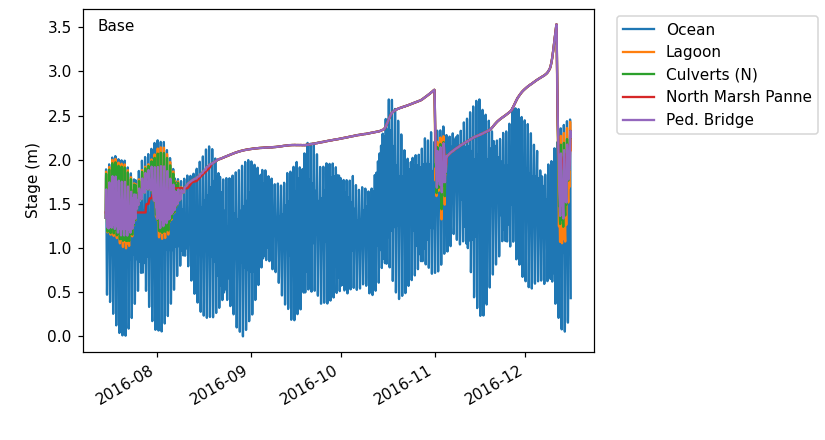

<IPython.core.display.Javascript object>


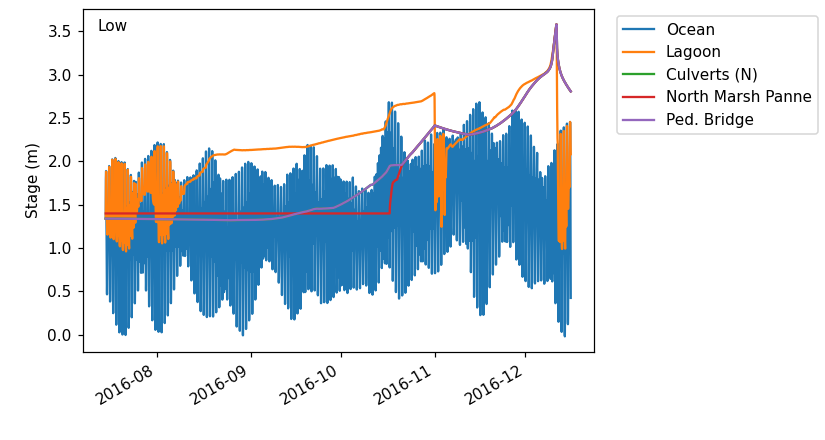

<IPython.core.display.Javascript object>


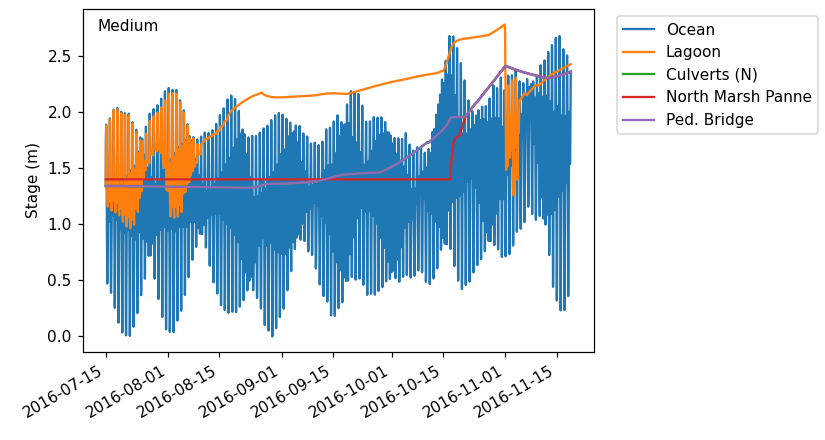

<IPython.core.display.Javascript object>


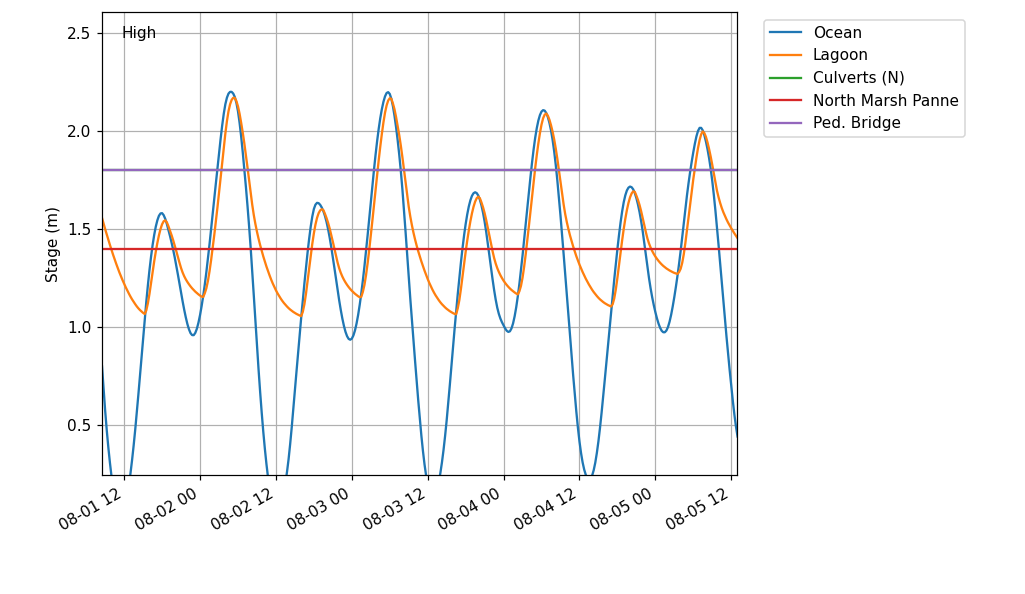

In [14]:
for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-{rec.name}.png'),
                dpi=150)

In [15]:
runs['mu']=None
for i in range(len(runs)):
    mu=multi_ugrid.MultiUgrid(runs.model.values[i].map_outputs())
    runs['mu'].values[i]=mu

In [20]:
mu.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9257, mesh2d_nFaces: 5782, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3476, time: 68)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.528e+05 ... 5.533e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.123e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.528e+05 ... 5.533e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.123e+06
  * time                         (time) datetime64[ns] 2016-07-15 ... 2016-11-26
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ...
    mesh2d                       int32 ...
    mesh2d_node_z                (mesh2d_nNodes) float64 2.036 2.037 ... 4.298
    mesh2d_edge

Tidal Analysis
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.

Tidal prism



In [53]:
check_date=np.datetime64('2016-12-10 00:00')
t_idx=np.searchsorted(mu.time.values, check_date)

In [55]:
mu.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9039, mesh2d_nFaces: 5427, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3613, time: 78)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.526e+05 ... 5.526e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.125e+06 ... 4.124e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.526e+05 ... 5.526e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.125e+06 ... 4.124e+06
  * time                         (time) datetime64[ns] 2016-07-15 ... 2016-12-16
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ...
    mesh2d                       int32 ...
    mesh2d_node_z                (mesh2d_nNodes) float64 1.985 1.972 ... 0.5126
    mesh2d_edg

<IPython.core.display.Javascript object>


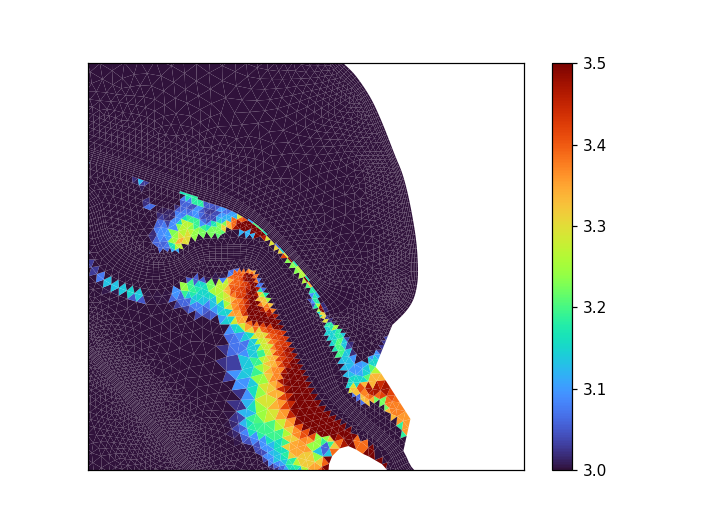

<IPython.core.display.Javascript object>


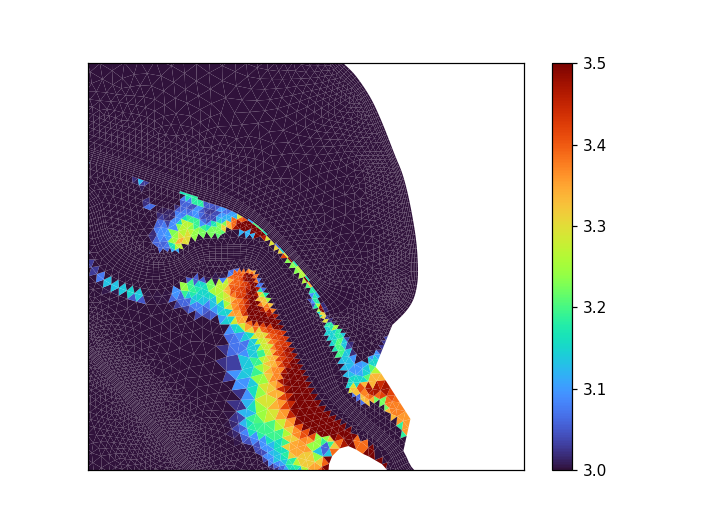

<IPython.core.display.Javascript object>


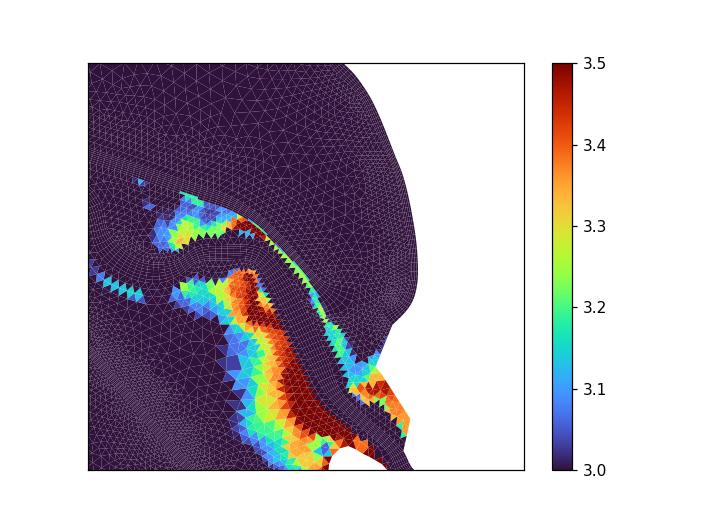

<IPython.core.display.Javascript object>


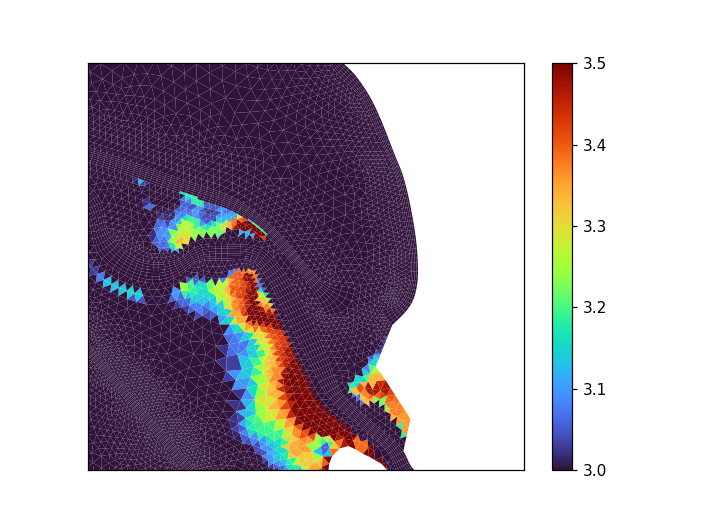

In [19]:
zoom=(552884.239654878, 553379.5380276634, 4124024.3290092396, 4124485.6754774386)

for i in range(len(runs)):
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    mu=runs['mu'].values[i]
    #ccoll=mu.grid.plot_cells(values=mu['mesh2d_ucmag'].isel(time=t_idx),
    #                         cmap='turbo')
    #ccoll.set_clim([0,2])

    #ccoll=mu.grid.plot_cells(values=mu['mesh2d_waterdepth'].isel(time=t_idx),
    #                         cmap='turbo')
    #ccoll.set_clim([0,3])
    
    ccoll=mu.grid.plot_cells(values=mu['mesh2d_flowelem_bl'].values,
                             cmap='turbo')
    ccoll.set_clim([3.0,3.5])
    
    #ccoll=mu.grid.plot_cells(values=mu['mesh2d_s1'].isel(time=t_idx),
    #                         cmap='turbo')
    #ccoll.set_clim([2,3.5])

    #ax.text(0.02,0.9,mu.time.values[t_idx],transform=ax.transAxes)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    plt.colorbar(ccoll)
    ax.axis(zoom)

In [46]:
# Does not look like the bathy is getting updated!

(552884.239654878, 553379.5380276634, 4124024.3290092396, 4124485.6754774386)